# Python: Impact of 401(k) on Financial Wealth

### Overview

In this real-data example, extended from [the Double ML package examples](https://docs.doubleml.org/stable/examples/py_double_ml_pension.html), we will study the effect of 401(k) eligibility and participation on accumulated assets using observational data. More precisely, we will focus on:

- Building a causal graph to represent the underlying data-generating process of the and discuss identification assumptions.

- introducing how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the effect of 401(k) eligibility and participation on accumulated assets.


### Context

The 401(k) data set has been analyzed in several studies, among others [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060). 401(k) plans are pension accounts sponsored by employers. The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job.

## Data

The preprocessed data can be fetched by calling [fetch_401K()](https://docs.doubleml.org/stable/api/generated/doubleml.datasets.fetch_401K.html#doubleml.datasets.fetch_401K). Note that an internet connection is required for loading the data.

In [4]:
!pip install doubleml
!pip install skrub

import doubleml as dml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

from doubleml.datasets import fetch_401K
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skrub import TableReport
from skrub._interpolation_joiner import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 9.7 MB/s eta 0:00:00


In [9]:
plt.rcParams["figure.figsize"] = 10.0, 7.5
sns.set_style(
    "whitegrid",
    {
        "axes.spines.top": False,
        "axes.spines.bottom": False,
        "axes.spines.left": False,
        "axes.spines.right": False,
    },
)
colors = sns.color_palette("colorblind")

In [6]:
data = fetch_401K(return_type="DataFrame")

In [7]:
print(data.head())

      nifa  net_tfa        tw  age      inc  fsize  educ  db  marr  twoearn  \
0      0.0      0.0    4500.0   47   6765.0      2     8   0     0        0   
1   6215.0   1015.0   22390.0   36  28452.0      1    16   0     0        0   
2      0.0  -2000.0   -2000.0   37   3300.0      6    12   1     0        0   
3  15000.0  15000.0  155000.0   58  52590.0      2    16   0     1        1   
4      0.0      0.0   58000.0   32  21804.0      1    11   0     0        0   

   e401  p401  pira  hown  
0     0     0     0     1  
1     0     0     0     1  
2     0     0     0     0  
3     0     0     0     1  
4     0     0     0     1  


# Column descriptions from [hdm R package](https://search.r-project.org/CRAN/refmans/hdm/html/pension.html)

| Variable | Description |
|----------|-------------|
| nifa | Non-401(k) financial assets |
| net_tfa | Net total financial assets (often used as the Outcome Variable) |
| tw | Total wealth |
| age | Age of the individual |
| inc | Annual income (usually in US dollars or thousands) |
| fsize | Family size (number of household members) |
| educ | Education (measured in years of schooling) |
| db | Defined benefit pension (binary: 1 if present, 0 otherwise) |
| marr | Marital status (binary: 1 if married, 0 otherwise) |
| twoearn | Two-earner household (binary: 1 if both spouses work) |
| e401 | Eligibility for 401(k) plan (often the Treatment Variable) |
| p401 | Participation in 401(k) plan |
| pira | Participation in an Individual Retirement Account (IRA) |
| hown | Home ownership (binary: 1 if homeowner, 0 otherwise) |


## Skrub TableReport to get a quick overview of the data

In [12]:

TableReport(data)

,,,,,,,,,,,,,,


The data consist of 9,915 observations at the household level drawn from the 1991 Survey of Income and Program Participation (SIPP).  All the variables are referred to 1990. We use net financial assets (*net\_tfa*) as the outcome variable, $Y$,  in our analysis. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts.

Among the $9915$ individuals, $3682$ are eligible to participate in the program. The variable *e401* indicates eligibility and *p401* indicates participation, respectively.

### 📝TODO: Compute a barplot for the variables 'e401' and 'p401k'

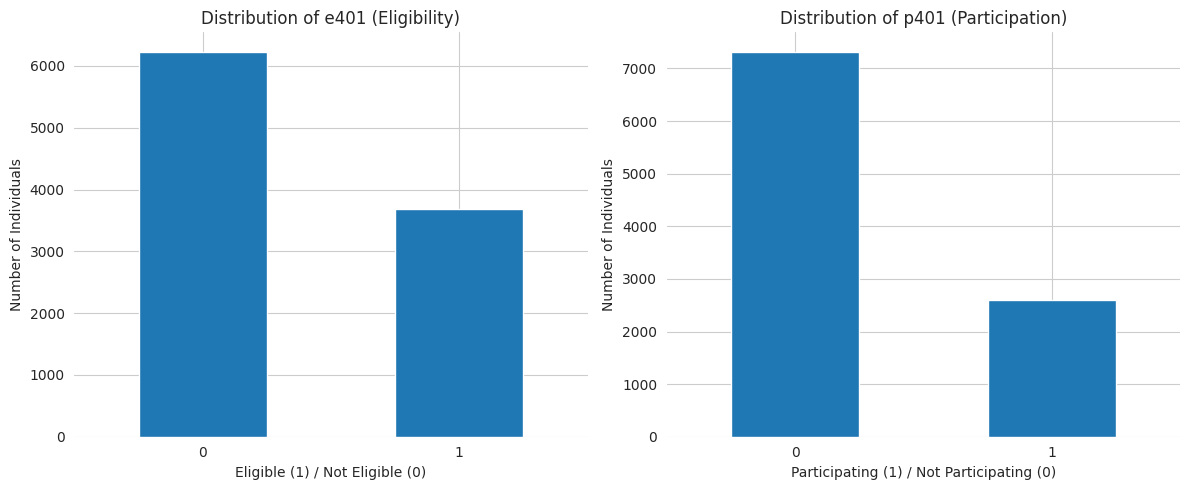

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
data['e401'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of e401 (Eligibility)')
plt.xlabel('Eligible (1) / Not Eligible (0)')
plt.ylabel('Number of Individuals')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
data['p401'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of p401 (Participation)')
plt.xlabel('Participating (1) / Not Participating (0)')
plt.ylabel('Number of Individuals')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Eligibility is highly associated with financial wealth:
### 📝TODO: Draw a visualisation that displays clearly this association.

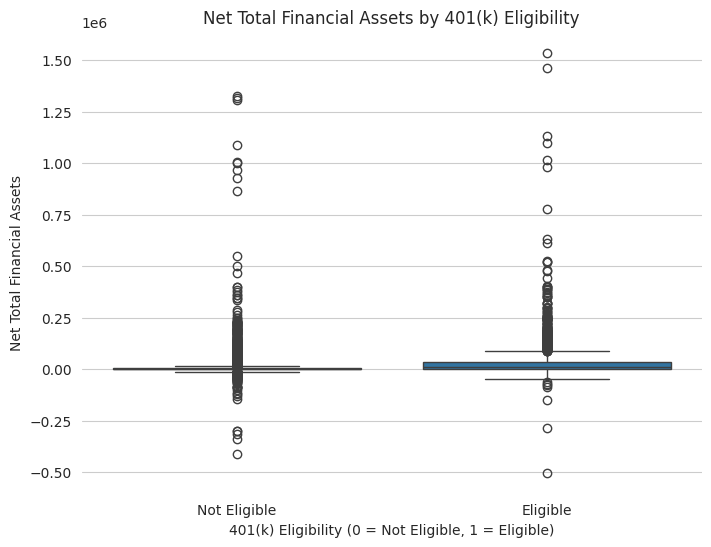

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='e401', y='net_tfa', data=data)
plt.title('Net Total Financial Assets by 401(k) Eligibility')
plt.xlabel('401(k) Eligibility (0 = Not Eligible, 1 = Eligible)')
plt.ylabel('Net Total Financial Assets')
plt.xticks(ticks=[0, 1], labels=['Not Eligible', 'Eligible'])
plt.show()

As a first estimate, we calculate the unconditional average predictive effect (APE) of 401(k) eligibility on accumulated assets. This effect would correspond to the average treatment effect if 401(k) eligibility would be assigned to individuals in an entirely randomized way. The unconditional APE of e401 is about $19559$.
Among the $3682$ individuals that are eligible, $2594$ decided to participate in the program. The unconditional APE of p401 is about $27372$.

### 📝TODO: Compute the naive estimate (randomization case) for the eligibility and the participation variables to recover these naive estimates.

In [20]:
APE = data.groupby('e401')['net_tfa'].mean()

print(f"Unconditional APE for e401: {APE[1] - APE[0]}")

Unconditional APE for e401: 19559.34375


As discussed, these estimates are biased since they do not account for saver heterogeneity and endogeneity of participation.

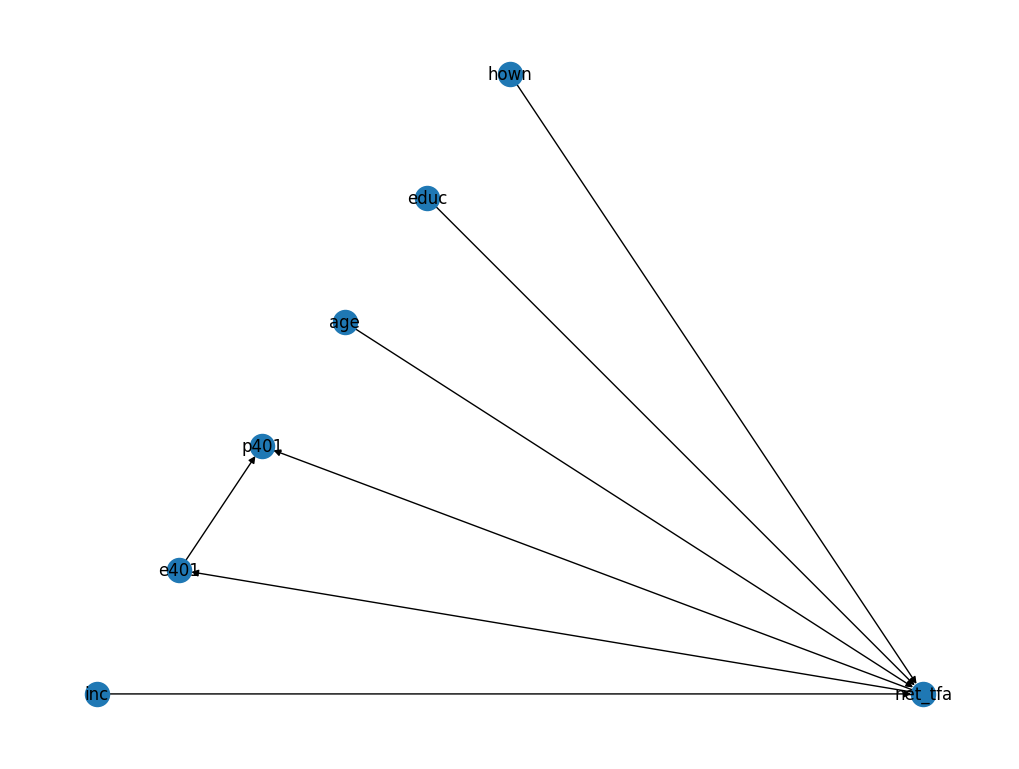

In [30]:
# Causal graph representation
# ### 📝TODO: Use the `networkx` package to represent the causal graph of the data generating process. Think a little bit about what edges seems reasonable to include or not. To find the full variable labels, you can check the documentation [here](https://search.r-project.org/CRAN/refmans/hdm/html/pension.html).

import pgmpy
from pgmpy.base.DAG import DAG

causal_graph = nx.DiGraph(
    [
        ("inc", "net_tfa"),
        ("age", "net_tfa"),
        ("educ", "net_tfa"),
        ("hown", "net_tfa"),
        ("net_tfa", "e401"),
        ("e401", "p401"),
        ("net_tfa", "p401")
    ]
)

G = DAG(causal_graph)

nx.draw_planar(G, with_labels=True)
plt.show()



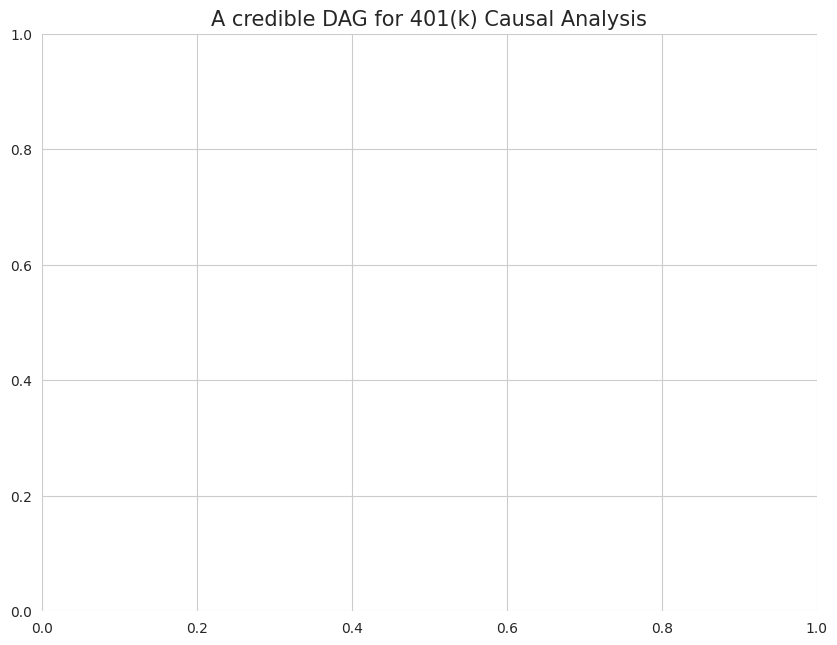

In [36]:
# Define the causal relationships
# Confounders for e401 : hypothesis is that these variables affect the choice of the employer and thus the eligibility to a 401(k) plan
confounders_e401 = [list(G.predecessors("e401"))]
# Confounders for p401 : ie. variables affecting the proportion to save and thus the decision to participate in a 401(k) plan
confounders_p401 = [list(G.predecessors("p401"))]

edges = [list(nx.all_simple_paths(G.to_undirected(), "e401", "net_tfa"))]

for confounder in confounders_e401:
    edges.append((confounder, "e401"))
    edges.append((confounder, "net_tfa"))

for confounder in confounders_p401:
    edges.append((confounder, "p401"))
    edges.append((confounder, "net_tfa"))

plt.title("A credible DAG for 401(k) Causal Analysis", fontsize=15)
plt.show()

## Using the `DoubleML` package

Let's use the package [DoubleML](https://docs.doubleml.org/stable/index.html) to estimate the average treatment effect of 401(k) eligibility, i.e. `e401` on net financial assets `net_tfa`.

## Estimating the Average Treatment Effect of 401(k) Eligibility on Net Financial Assets

We first look at the treatment effect of `e401` on net total financial assets. We give estimates of the ATE in the Partially Linear Model (PLM)

$$
\begin{equation*}
Y = D \theta_0 + g_0(X)+ \zeta, \quad E[\zeta \mid D,X]= 0,
\end{equation*}
$$

where X are the confounders: eg. variables on marital status, two-earner status, defined benefit pension status, IRA participation, home ownership, family size, education, age, and income.

We will use only the untransformed variables with linear (lasso) and nonlinear methods, for example random forests or boosting. There are, of course, multiple ways how the statistical models can be specified even more flexibly, for example including interactions of variable and higher order interaction. However, for the sake of simplicity we stick to the specification above. Users who are interested in varying the model can adapt the code below accordingly, for example to implement the original specification in [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060).

We will estimate the average treatment effect (ATE) of 401(k) eligibility on net financial assets both in the partially linear regression (PLR) model using different sets of covariates and different machine learning models.
The PLR model is implemented in the [DoubleMLPLR](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) class and can be written as :
$$
\begin{aligned}
Y &= D\theta_0 + g_0(X) + \zeta, &\quad E[\zeta \mid D,X]= 0,\\
D &= m_0(X) +  V, &\quad E[V \mid X] = 0.
\end{aligned} $$

Y is the outcome variable and D is the policy variable of interest. The high-dimensional vector X consists of other confounding covariates, and $\zeta$ and V are stochastic errors.

### The Data Backend: `DoubleMLData`

To start our analysis, we initialize the data backend, i.e., a new instance of a [DoubleMLData](https://docs.doubleml.org/dev/api/generated/doubleml.data.DoubleMLData.html#doubleml.data.DoubleMLData) object. We implement the regression model by using scikit-learn's `PolynomialFeatures` class.

To implement the different models (basic small, basic full, flexible small and flexible full), we generate different data backends:
- `data_dml_small`
- `data_dml_full`
- `data_dml_flex_small`
- `data_dml_flex_full`

In [37]:
# Set up basic model: Specify variables for data-backend
features_small = [
    "inc",
    "age",
    "educ",
    "hown",
]
features_full = [
    *features_small,
    "fsize",
    "marr",
    "twoearn",
    "db",
    "pira",
]

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_small = dml.DoubleMLData(
    data, y_col="net_tfa", d_cols="e401", x_cols=features_small
)
data_dml_full = dml.DoubleMLData(
    data, y_col="net_tfa", d_cols="e401", x_cols=features_full
)

In [38]:
print(data_dml_small)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['inc', 'age', 'educ', 'hown']
Instrument variable(s): None
No. Observations: 9915
------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 14 entries, nifa to hown
dtypes: float32(4), int8(10)
memory usage: 251.9 KB



### Partially Linear Regression Model (PLR)

We start using lasso to estimate the function $g_0$ and $m_0$ in the PLR model:

To estimate the causal parameter $\theta_0$ here, we use double machine learning with 3-fold cross-fitting.

Estimation of the nuisance components $g_0$ and $m_0$, is based on the lasso with cross-validated choice of the penalty term , $\lambda$, as provided by [scikit-learn](https://scikit-learn.org). We load the learner by initializing instances from the classes [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) and [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Hyperparameters and options can be set during instantiation of the learner. Here we specify that the lasso should use that value of $\lambda$ that minimizes the cross-validated mean squared error which is based on 5-fold cross validation.

We start by estimation the ATE in the basic model and then repeat the estimation in the flexible model.

Initialize learners
### 📝TODO: Instantiate a lasso and a logistic lasso with cross-validated choice of the penalty term. Don't forget to asd a standard scaler in a pipeline.
For the lasso coefficients, use a grid of ten values between 0.0001 and 1 (logarithmic scale).

In [42]:
lasso = make_pipeline(
    StandardScaler(),
    LassoCV(cv = 5, random_state= 42))

lasso_class= make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(cv = 5, random_state= 42))

In [43]:
np.random.seed(123)
# Initialize DoubleMLPLR model
dml_plr_lasso_small = dml.DoubleMLPLR(
    data_dml_small, ml_l=lasso, ml_m=lasso_class, n_folds=3
)

dml_plr_lasso_small.fit(store_predictions=True)
lasso_summary_small = dml_plr_lasso_small.summary
print(lasso_summary_small)

             coef      std err         t     P>|t|       2.5 %       97.5 %
e401  5019.944834  1502.625934  3.340781  0.000835  2074.85212  7965.037547


In [44]:
# Estimate the ATE in the full model with lasso

np.random.seed(123)
dml_plr_lasso_full = dml.DoubleMLPLR(
    data_dml_full, ml_l=lasso, ml_m=lasso_class, n_folds=3
)

dml_plr_lasso_full.fit(store_predictions=True)
lasso_summary_full = dml_plr_lasso_full.summary

print(lasso_summary_full)

             coef      std err         t     P>|t|        2.5 %       97.5 %
e401  5951.982198  1461.435626  4.072695  0.000046  3087.621004  8816.343391


Alternatively, we can repeat this procedure with other machine learning methods, for example a random forest learner as provided by the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class in [scikit-learn](https://scikit-learn.org).

 ### 📝TODO: Replicate the previous analysis but using Random Forest models.

In [ ]:
# Random Forest small model

random_forest = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)

np.random.seed(123)
# Initialize Forest model
dml_plr_forest_small = dml.DoubleMLPLR(
    data_dml_small, ml_l=lasso, ml_m=lasso_class, n_folds=3
)

dml_plr_lasso_small.fit(store_predictions=True)
lasso_summary_small = dml_plr_lasso_small.summary


print(forest_summary_small)

In [ ]:
# Random forest full model

print(forest_summary_full)

We can also experiment with gradient boosting.
## 📝TODO: Replicate the previous analysis but using HistGradientBoosting.

In [ ]:
# Boosted Trees small model

print(boost_summary_small)

In [ ]:
# Boosted Trees full model

print(boost_summary_full)

Let's sum up the results:

In [ ]:
plr_summary = pd.concat(
    (
        lasso_summary_small,
        lasso_summary_full,
        forest_summary_small,
        forest_summary_full,
        boost_summary_small,
        boost_summary_full,
    )
)
plr_summary.index = [
    "lasso (small)",
    "lasso (full)",
    "forest (small)",
    "forest (full)",
    "boost (small)",
    "boost (full)",
]
print(plr_summary[["coef", "2.5 %", "97.5 %"]])

In [ ]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary["coef"] - plr_summary["2.5 %"]
errors[1, :] = plr_summary["97.5 %"] - plr_summary["coef"]
plt.errorbar(plr_summary.index, plr_summary.coef, fmt="o", yerr=errors)
plt.ylim([0, 12500])

plt.title("Partially Linear Regression Model (PLR)")
plt.xlabel("ML method")
_ = plt.ylabel("Coefficients and 95%-CI")

## Adding model selection for flexible models.
In the previous section, we did not perform parameter search for the flexible models. Here, we will illustrate how to perform model selection using the `DoubleML` package and sklearn pipelines.

### 📝TODO: Replicate the previous model using a pipeline with randomized search and histgradient boosting for the nuisance models.

📝TODO What happens if we use a super small set of covariates? Eg. not take into account the income.
📝TODODo you find a minimal set of covariates that you would recommend to absolutely include in the model?
### 📝TODO: Try with other sets of covariates for a flexible model and a lasso.

In [ ]:
features_super_small = [

]
print(boost_pipe_summary_super_small)

In [ ]:
print(lasso_plr_summary_super_small)

______

**Acknowledgement**

We would like to thank [Jannis Kueck](https://www.dice.hhu.de/en/dice/people/professors-1/kueck) for sharing [the kaggle notebook](https://www.kaggle.com/janniskueck/pm5-401k). The pension data set has been analyzed in several studies, among others [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060).

